<h2>Importing necessary libraries</h2> 


In [108]:
%matplotlib inline

# Make some of the relevant imports
import cv2 # OpenCV for transformation
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

#import imageio
#imageio.plugins.ffmpeg.download()

import os
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

**<h2>Importing a Random Image</h2>**

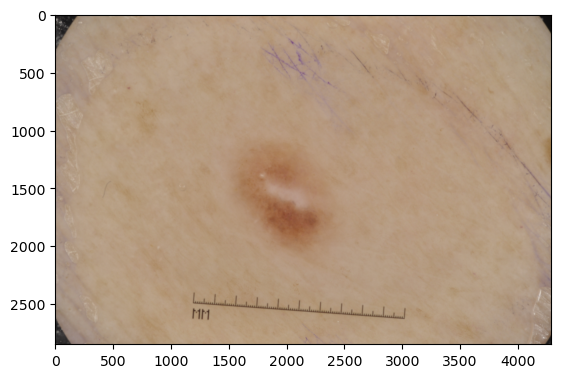

In [109]:
path = '/home/mhpromit7473/Documents/ISIC_Dataset/images/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)
plt.show()

**<h2>Loading Matadata</h2>**

In [110]:
metadata = pd.read_csv('/home/mhpromit7473/Documents/ISIC_Dataset/metadata.csv')
print(metadata.head())

       image_id age_approximate     sex
0  ISIC_0000000              55  female
1  ISIC_0000001              30  female
2  ISIC_0000002              60  female
3  ISIC_0000003              30    male
4  ISIC_0000004              80    male


**<h2>Custom Dataset Class:</h2>**
**<h4>Create a custom dataset class to handle loading images and superpixel images</h4>**

In [111]:
class SkinLesionDataset(Dataset):
    def __init__(self, image_dir, superpixel_dir=None, transform=None):
        self.image_dir = image_dir
        self.superpixel_dir = superpixel_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(image_path).convert("RGB")

        # Load superpixel image if available
        superpixel = None  # Default to None
        if self.superpixel_dir:
            superpixel_path = os.path.join(self.superpixel_dir, self.images[idx].replace('.jpg', '_superpixels.png'))
            if os.path.exists(superpixel_path):  # Check if the superpixel file exists
                superpixel = Image.open(superpixel_path).convert("RGB")  # Adjust according to your format

        # Apply transformations
        if self.transform:
            image = self.transform(image)
            if superpixel is not None:
                superpixel = self.transform(superpixel)

        return (image, superpixel) if superpixel is not None else image


**<h2>Image Preprocessing</h2>**

In [112]:
# Defineing transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for RGB images
])

# Specify directories
image_dir = '/home/mhpromit7473/Documents/ISIC_Dataset/images'
superpixel_dir = '/home/mhpromit7473/Documents/ISIC_Dataset/superpixels'

# Creating the dataset
dataset = SkinLesionDataset(image_dir=image_dir, superpixel_dir=superpixel_dir, transform=transform)

# Creating DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Example of iterating through the DataLoader
for images, superpixels in dataloader:
    print(images.shape)  # Should be [16, 3, 256, 256]
    if superpixels is not None:
        print(superpixels.shape)  # Should be [16, 3, 256, 256] if superpixels are available
    break


torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])


<h3 style="color:#2F4F4F;">DullRazor Algorithm</h3>

<p style="color:#696969;"><strong>Removing Hair from Sample Images</strong></p>

<p>The <strong>DullRazor</strong> algorithm is used to effectively remove hair from melanoma images, ensuring that skin lesions are more visible and easier to analyze.</p>

In [ ]:
# Specify your output directory
output_directory = '/home/mhpromit7473/Documents/ISIC_Dataset/cleaned_images'

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for i in range(len(dataset)):
    # Load and process the original image
    image, _ = dataset[i]  # Get the first image from the dataset
    
    # Convert tensor to NumPy array
    image_np = image.permute(1, 2, 0).numpy()  # Convert from CHW to HWC format
    
    # Rescale the image back to [0, 1]
    image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))
    
    # Scale to [0, 255] for displaying
    image_np = (image_np * 255).astype(np.uint8)
    
    # Display the original image using plt
    # plt.imshow(image_np)
    # plt.axis('off')  # Turn off axis labels
    # plt.show()


    # # Convert the image from BGR to RGB for displaying with matplotlib
    # image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    
    # ----------------------- DULL RAZOR (REMOVE HAIR) -----------------------
    
    # Convert the original image to grayscale
    grayScale = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    
    # Apply the Black Hat filter to extract hair features
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))  # 9x9 rectangular kernel
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    
    # Apply a Gaussian filter to smooth the blackhat image
    bhg = cv2.GaussianBlur(blackhat, (3,3), cv2.BORDER_DEFAULT)
    
    # Perform binary thresholding to create a mask
    ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
    
    # In-paint the original image using the mask to remove hair
    dst = cv2.inpaint(image_np, mask, 6, cv2.INPAINT_TELEA)
    
    # Convert cleaned image from BGR to RGB for displaying with matplotlib
    dst_rgb = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    
    # # ------------------------ DISPLAY IMAGES ------------------------#
    # # Set up the subplots to display multiple images
    # fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    # 
    # # Display the original image
    # axs[0, 0].imshow(image_np)
    # axs[0, 0].set_title('Original Image')
    # axs[0, 0].axis('off')
    # 
    # # Display the grayscale image
    # axs[0, 1].imshow(grayScale, cmap='gray')
    # axs[0, 1].set_title('Grayscale Image')
    # axs[0, 1].axis('off')
    # 
    # # Display the blackhat filtered image
    # axs[0, 2].imshow(blackhat, cmap='gray')
    # axs[0, 2].set_title('Blackhat Image')
    # axs[0, 2].axis('off')
    # 
    # # Display the binary mask
    # axs[1, 0].imshow(mask, cmap='gray')
    # axs[1, 0].set_title('Binary Mask')
    # axs[1, 0].axis('off')
    # 
    # # Display the in-painted (cleaned) image
    # axs[1, 1].imshow(dst_rgb)  # Use the converted RGB image
    # axs[1, 1].set_title('Cleaned Image')
    # axs[1, 1].axis('off')
    # 
    # # Hide the last subplot (axs[1, 2]) since we only have 5 images
    # axs[1, 2].axis('off')
    # 
    # # Show the plot
    # plt.tight_layout()
    # plt.show()
    
    
    cv2.imwrite(os.path.join(output_directory, f'cleaned_image_{i}.png'), dst)
